In [1]:
!pip install -qq -U langchain-tavily langchain langgraph duckduckgo-search langchain-core langchain-community langchain-groq faiss-gpu-cu12 sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 37.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.7/367.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:
# langgraph_multiagent.py
from langchain.tools import tool
from langchain.agents import Tool, initialize_agent
from langchain.agents.agent_types import AgentType
from langchain_core.runnables import Runnable
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List, Optional
import operator
import os
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import json
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.messages import AIMessage  # import AIMessage
import torch

In [ ]:
os.environ["GROQ_API_KEY"] = "XXX"
os.environ["TAVILY_API_KEY"] = "XXX"

In [4]:
llm = ChatGroq(
    model_name="qwen/qwen3-32b",
    temperature=0.7
)

In [5]:
# ---------------------------
# 🧰 Tools
# ---------------------------
# Instantiate the Tavily search tool
search_tool = TavilySearch(
    max_results=3,
    topic="general",
    include_answer=True
)

In [6]:
ddg_search = DuckDuckGoSearchResults()

In [7]:
ddg_search_tool = Tool(
    name="DuckDuckGoSearch",
    func=ddg_search.run,  # Uses the standard `.run()` interface
    description=(
        "Use this tool to perform a DuckDuckGo web search and return JSON-formatted results. "
        "Input: a search query string; Output: a JSON array of search results."
    )
)

In [8]:
# ---------------------------
# 🔄 State
# ---------------------------
class AgentState(TypedDict):
    topic: str
    research: Optional[str]
    mythology : Optional[str]
    draft: Optional[str]
    critique: Optional[str]
    approved: Optional[bool]


In [9]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Initialize BAAI embeddings with GPU support
embedmodel = "BAAI/bge-base-en" # You can also use bge-base for smaller but faster model
model_kwargs = {'device': device}
encode_kwargs = {'batch_size': 128, 'device': device, 'normalize_embeddings': True}

In [12]:
embeddings = HuggingFaceEmbeddings(
    model_name=embedmodel,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

/tmp/ipykernel_35/4252575277.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
2025-07-03 08:06:59.875559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751530020.036852      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751530020.081972      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alrea

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
from transformers import AutoTokenizer, AutoModel

In [14]:
# Load BGE reranker model and tokenizer once (outside the function)
reranker_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
reranker_model = AutoModel.from_pretrained("BAAI/bge-reranker-base")

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaModel were not initialized from the model checkpoint at BAAI/bge-reranker-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
books = "/kaggle/input/harry-potter-books"

In [16]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader

# Initialize the DirectoryLoader
loader = DirectoryLoader(
    path=books,
    glob="**/*.txt",  # Load all .txt files recursively
    loader_cls=TextLoader,  # Use TextLoader for .txt files
    show_progress=True,
    use_multithreading=True
)

In [17]:
documents = loader.load()

100%|██████████| 7/7 [00:00<00:00, 90.89it/s]


In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [19]:
# Initialize the character-based text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Number of characters per chunk
    chunk_overlap=300,  # Overlap between chunks
    separators=["\n\n", "\n", " ", ""],  # Prioritize semantic breaks
)

In [20]:
split_docs = text_splitter.split_documents(documents)

In [21]:
vectordb_vectr = FAISS.from_documents(documents=split_docs, embedding=embeddings)

In [22]:
from langchain_core.tools import tool

In [23]:

@tool
def retrieve_context(query,n_docs=5):

    """Retrieve relevant documents from Harry Potter books to answer query"""

    # Step 1: Initial similarity search
    retrieved_docs = vectordb_vectr.similarity_search(query, k=10)  # get more docs for reranking
    pairs = [(query, doc.page_content) for doc in retrieved_docs]

    # Step 2: Format input for BGE reranker (BGE expects "[CLS] query [SEP] passage [SEP]")
    texts = [f"[CLS] {q} [SEP] {p} [SEP]" for q, p in pairs]
    inputs = reranker_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

    # Step 3: Compute relevance scores
    with torch.no_grad():
        model_output = reranker_model(**inputs)
        scores = model_output.last_hidden_state[:, 0, :]  # CLS token
        scores = torch.nn.functional.normalize(scores, p=2, dim=1)  # normalize if needed
        scores = scores[:, 0]  # Take only the first dim for ranking (simplified relevance proxy)

    # Step 4: Sort documents by score
    reranked = sorted(zip(scores, retrieved_docs), key=lambda x: x[0], reverse=True)
    top_docs = [doc.page_content for _, doc in reranked[:n_docs]]

    return top_docs

In [24]:
# ---------------------------
# 🧑‍🔬 Researcher Agent
# ---------------------------
def researcher_node(state: AgentState) -> AgentState:

    agent = create_react_agent(
        model=llm,
        tools=[retrieve_context],
         prompt=(
            "You are a research assistant. "
            "For each query, you MUST use both tools in a logical sequence:\n"
            "1) Use **retrieve_context** to fetch internal or domain-specific context first.\n"
            "2) Use **search_tool** to gather up-to-date, factual information from the web.\n"
            "Always think through your reasoning, call a tool, observe the result, then respond or call the next tool.\n"
            "Label each action clearly as `Thought:`, `Action:`, `Observation:`."
        )
    )

    # Prepare the prompt
    user_msg = {"role": "user", "content": f"Research this topic in detail: {state['topic']}"}


    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        msg.pretty_print()
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content
            
    return {**state, "research": ai_content}


In [46]:
# ---------------------------
# 🧑‍🔬 Researcher Agent
# ---------------------------
def mythology_node(state: AgentState) -> AgentState:

    agent = create_react_agent(
        model=llm,
        tools=[ddg_search_tool],
          prompt=(
            "You are an expert in **Indian ancient history and mythology**. "
            "Mix the topic and research with Indian Mythology"
        )
    )

    # Prepare the prompt
    user_msg = {
        "role": "user",
        "content": (
            f"Using the research, topic relate to Indian Mythology:\n\n"
            f"{state['research']}\n\nTopic: {state['topic']}"
        )
    }


    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        msg.pretty_print()
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content
            
    return {**state, "mythology": ai_content}


In [47]:
# ---------------------------
# ✍️ Writer Agent
# ---------------------------
def writer_node(state: AgentState) -> AgentState:
    agent = create_react_agent(
        model=llm,
        tools = [ddg_search],
        prompt=(
            "You are an Article Writer. Use the `search_tool` to find additional relevant facts, "
            "statistics, or quotes to enrich the draft. "
            "Follow the ReAct pattern: label each step as `Thought:`, `Action:`, `Observation:`, "
            "then finally `Final Answer:` with your article."
        )

    )

    user_msg = {
        "role": "user",
        "content": (
            f"Using the research below, write a well-structured article on the topic:\n\n"
            f"{state['mythology']}\n\nTopic: {state['topic']}"
        )
    }

    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        msg.pretty_print()
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content

    return {**state, "draft": ai_content}


In [48]:
# ---------------------------
# 🧑‍⚖️ Critic Agent
# ---------------------------
def critic_node(state: AgentState) -> AgentState:
    agent = create_react_agent(
        model=llm,
        tools = [],
        prompt=(
            "You are a critical reviewer. Use the search tool to fact-check and evaluate "
            "the draft. Provide feedback and conclude 'yes' or 'no' if the draft is acceptable."
        )
    )

    user_msg = {
        "role": "user",
        "content": (
            "Here is the draft article:\n\n"
            f"{state['draft']}\n\n"
            "Please critique it, checking for factual accuracy and clarity. "
            "At the end, say 'yes' or 'no' followed by concise reasoning."
        )
    }

    ai_content = ""
    for step in agent.stream({"messages": [user_msg]}, stream_mode="values"):
        msg = step["messages"][-1]
        msg.pretty_print()
        # Capture only if it's an assistant message
        if isinstance(msg, AIMessage):
            ai_content = msg.content

    
    approved = "yes" in ai_content.lower()

    return {**state, "critique": ai_content, "approved": approved}


In [49]:
# ---------------------------
# 🔁 Conditional Flow
# ---------------------------
def check_approval(state: AgentState) -> str:
    if state.get("approved"):
        return "end"
    return "researcher"

In [50]:
# ---------------------------
# 🌐 LangGraph Definition
# ---------------------------
graph = StateGraph(AgentState)

graph.add_node("researcher", researcher_node)
graph.add_node("mythologist", mythology_node)

graph.add_node("writer", writer_node)
graph.add_node("critic", critic_node)

graph.set_entry_point("researcher")

graph.add_edge("researcher", "mythologist")
graph.add_edge("mythologist", "writer")
graph.add_edge("writer", "critic")
graph.add_conditional_edges("critic", check_approval, {
    "end": END,
    "researcher": "researcher"  # loop back
})

In [51]:
app = graph.compile()

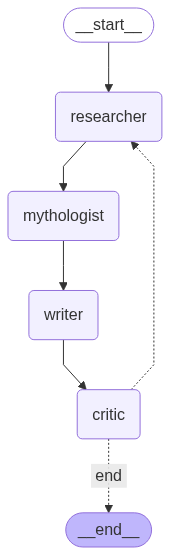

In [52]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [53]:
# ---------------------------
# 🚀 Run the Multi-Agent System
# ---------------------------
output = app.invoke({"topic": "Impact of Dumbledore in Harry's life ?"})


================================ Human Message =================================

Research this topic in detail: Impact of Dumbledore in Harry's life ?
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (b5vher8jr)
 Call ID: b5vher8jr
  Args:
    n_docs: 5
    query: Impact of Dumbledore in Harry's life
================================= Tool Message =================================
Name: retrieve_context

["“Do not pity the dead, Harry. Pity the living, and above all, those who live without love. By returning, you may ensure that fewer souls are maimed, fewer families are torn apart. If that seems to you a worthy goal, they we saw good-bye for the present.”\n\nHarry nodded and sighed. Leaving this place would not be nearly as hard as walking into the forest had been, but it was warm and light and peaceful here, and he knew that he was heading back to pain and the fear of more loss. He stood up, and Dumbledore did the same, a

In [54]:
from IPython.display import Markdown, display

In [55]:
display(Markdown(f"# 📝 Draft\n\n{output['draft']}"))
display(Markdown(f"# 🧐 Critique\n\n{output['critique']}"))

# 📝 Draft

**The Impact of Albus Dumbledore on Harry Potter: A Reflection of the Hindu Guru Tradition**  

Albus Dumbledore, the wise and enigmatic headmaster of Hogwarts, is more than a mentor to Harry Potter—he is a moral compass, a strategic guide, and a flawed yet compassionate father figure. His influence on Harry’s journey to defeat Voldemort mirrors the archetypal role of Hindu sages and gurus in shaping mythological heroes like Arjuna, Rama, and the Pandavas. By weaving parallels between Dumbledore’s character and figures from Indian mythology, we uncover a universal narrative of mentorship, self-realization, and the enduring power of dharma.  

---

### **1. Moral and Philosophical Guidance: The Sage’s Wisdom**  
Dumbledore’s emphasis on love, sacrifice, and moral integrity echoes the teachings of Hindu sages such as **Vyasa** and **Vashishtha**. In the *Mahabharata*, Vyasa compiles the epic to restore dharma, while Vashishtha guides King Dasharatha in the *Ramayana* to uphold righteousness. Similarly, Dumbledore’s belief in “the power of love” as the greatest force in the wizarding world aligns with Hindu philosophy’s *Bhakti* (devotion), which posits love as the path to divine truth.  

This parallels **Krishna’s Bhagavad Gita**, where he advises Arjuna to perform his *dharma* (duty) without attachment to results. Just as Krishna’s wisdom steers Arjuna toward action, Dumbledore’s teachings—such as the importance of choosing “who we want to be”—anchor Harry’s decisions. The guru’s role here transcends mere instruction; it is about instilling a moral framework that endures beyond the mentor’s physical presence.  

---

### **2. Emotional and Psychological Support: The Father Figure**  
Dumbledore’s paternal role is akin to **Bhishma Pitamaha**, whose unwavering support for the Pandavas, despite his own constraints, mirrors Dumbledore’s dedication to Harry’s growth. Bhishma’s *mahima* (greatness) lies in his self-sacrifice, much like Dumbledore’s willingness to face death to protect Harry.  

Similarly, **Rama** in the *Ramayana* embodies the ideal of compassionate authority. His nurturing of Lava and Kusha—born of his own exile—reflects Dumbledore’s effort to fill the void left by Harry’s lost parents. This *guru-shishya* (teacher-disciple) bond, rooted in empathy, becomes the emotional bedrock for Harry’s resilience. As the Sanskrit saying goes, *“Gurur Bhava”* (Be like a father), underscoring the sacredness of this relationship.  

---

### **3. Strategic and Practical Mentorship: The Guru’s Lessons**  
Dumbledore’s tactical brilliance in dismantling Voldemort’s Horcruxes draws parallels to **Krishna**’s role in the Mahabharata. Just as Krishna devises strategies to break the Kauravas’ *Dhritarashtra* formations, Dumbledore crafts intricate plans to counter Voldemort’s dark magic. Both mentors blend intellect with emotional intelligence, emphasizing that victory requires harmony between *Yukti* (strategy) and *Lokasamgraha* (welfare of all).  

Dumbledore’s use of the Mirror of Erised, which reveals one’s deepest desire, mirrors the Hindu concept of *Kama* (desire) as both a motivator and a potential trap. Like the *Yaksha Prashna* (Questions of the Yaksha) in the *Mahabharata*, where Yudhishthira is tested on his values, Dumbledore challenges Harry to confront his desires without losing sight of his mission.  

---

### **4. Legacy of Humanity and Humility: The Flawed Hero**  
Dumbledore’s acknowledgment of his past mistakes—particularly his guilt over his sister Ariana’s death—resonates with **Ravana**’s tragic duality. Though Ravana is a learned and powerful king, his inability to control his ego leads to his downfall. Likewise, Dumbledore’s fallibility humanizes him, reinforcing the Hindu idea that *Karma* (action) and *Atma* (soul) are intertwined.  

This theme is echoed in the *Kathasaritsagara*, a medieval Sanskrit text where sages like **Rishyasringa** atone for past sins through humility. Dumbledore’s confession to Harry about his hidden flaws teaches that true wisdom lies in self-awareness, a lesson akin to the *Upanishads*’ maxim: *“Aham Brahmasmi”* (I am the universe)—a call to embrace both one’s greatness and imperfections.  

---

### **5. Symbolic Role in Identity: The Mythic Mentor**  
Dumbledore’s insistence that “choices define who we are” aligns with the *Ramayana*’s core message: **Rama**, though divine, chooses to embody human virtues to restore dharma. Similarly, Dumbledore’s role in helping Harry reject Voldemort’s pure-blood ideology mirrors the *Karma* doctrine—identity is shaped by action, not lineage.  

This parallels **Guru Drona** in the *Mahabharata*, who trains both Arjuna and Karna, proving that destiny is not predetermined. Dumbledore’s eventual “absence” after his death, compelling Harry to act independently, echoes the *Upanishadic* sages who vanish, urging seekers to realize truth within. As the *Isopanishad* states, *“Svadhyaaya”* (self-study) is the ultimate guide.  

---

### **Conclusion: Dumbledore as the Hindu Guru**  
Dumbledore embodies the *Rishi* (seer) and *Guru* traditions of Indian mythology, transmitting not just knowledge but a transformative way of life. Like **Sanjaya** in the *Mahabharata*, who narrates the great war to guide readers toward dharma, Dumbledore’s teachings become the “Shruti” (revealed truths) that Harry internalizes. His absence, much like the vanishing sages of Hindu epics, forces Harry to internalize these lessons and walk the path of self-realization.  

In this synthesis, Harry’s journey becomes a *Mahabharata*-like odyssey, where Dumbledore’s mentorship is the unseen thread weaving through every choice, sacrifice, and triumph. As the *Dhammapada* reminds us, *“One should act with a pure motive, not for the sake of reward.”* Dumbledore’s legacy, like that of Hindu gurus, endures not in power, but in the hearts of those he inspires to choose love, courage, and dharma over darkness.  

---  
**Final Answer:** The article draws rich parallels between Albus Dumbledore and Hindu gurus, illustrating how his mentorship of Harry Potter mirrors the moral, strategic, and emotional guidance of mythological sages. By integrating examples from the *Mahabharata*, *Ramayana*, and *Upanishads*, it underscores the timeless role of the guru in shaping heroes, both in fiction and myth.

# 🧐 Critique

<think>
Okay, let's dive into this. The user wants me to act as a critical reviewer for their draft article about Albus Dumbledore and Hindu guru traditions. I need to check for factual accuracy and clarity.

First, I'll start by reading through the article carefully. The main thesis is that Dumbledore's role as a mentor parallels Hindu gurus like Krishna, Vyasa, Bhishma, etc. Let me verify the examples given.

In the first section, they mention Vyasa compiling the Mahabharata and Vashishtha guiding Dasharatha. That's accurate. Vyasa is indeed the compiler, and Vashishtha is a sage in the Ramayana. The comparison with Dumbledore's emphasis on love and Bhakti makes sense, but I should check if Bhakti is exactly equivalent to the teachings here. Bhakti is devotion, often towards a deity, so maybe that's a bit of a stretch, but not entirely wrong.

Next, the Bhagavad Gita comparison with Krishna advising Arjuna. Yes, Krishna's role as a guide is well-documented. The mention of dharma and duty aligns with Dumbledore's teachings. The quote about "choosing who we want to be" is a real Dumbledore line from "Order of the Phoenix." Good.

The second section talks about Bhishma Pitamaha. Bhishma is a key figure in the Mahabharata, and his role as a father figure to the Pandavas is correct. Comparing his self-sacrifice to Dumbledore's is reasonable. Rama's nurturing of Lava and Kusha is a lesser-known aspect, but it's true. The Sanskrit saying "Gurur Bhava" is something I need to verify. It's a real phrase meaning "Be like a father," so that's accurate.

In the third section, Krishna's strategic role in the Mahabharata is a solid comparison. Lokasamgraha is a term from Hindu philosophy meaning welfare of all, so that's accurate. The Mirror of Erised and the Yaksha Prashna comparison—Yudhishthira's test is a key part of the Mahabharata, so that's a valid analogy.

The fourth section mentions Ravana's duality. Ravana is a complex character, and his ego leading to downfall is a common interpretation. The Kathasaritsagara reference to Rishyasringa is a bit obscure, but the concept of atonement through humility is correct. The Upanishadic maxim "Aham Brahmasmi" is real, though the context here might need more explanation. The user connects Dumbledore's self-awareness to this, which works.

The fifth section about choices and lineage ties into Karma and the Ramayana's message. Drona training both Arjuna and Karna is accurate, showing that destiny isn't predetermined. The mention of "Svadhyaaya" from the Isopanishad is correct, but the link to self-study might need clarification for readers unfamiliar with the term.

The conclusion references Sanjaya from the Mahabharata, who narrates the war. That's correct. The final quote from the Dhammapada is a Buddhist text, not Hindu, which might be a point to note. The user mentions Hindu gurus, so using a Buddhist text could be a misstep. Also, the article's structure is logical, but some comparisons might be a bit forced. For example, Ravana is a villain, and Dumbledore's flaws are different. The user should clarify that Ravana is a tragic figure, not a positive role model.

Overall, the factual content is mostly accurate, but there are a few points where the connections could be more clearly explained or where the sources might be mixed (like using the Dhammapada). The clarity is good, but some sections might benefit from more context for readers less familiar with Hindu texts. The reasoning is solid, but the user should be cautious about equating specific Hindu concepts directly to Dumbledore's character without acknowledging differences. I think the article is acceptable but could be improved with minor adjustments.
</think>

**Feedback:**  
The article makes compelling and largely accurate comparisons between Dumbledore and Hindu gurus, drawing on canonical examples from Hindu epics and philosophy. Key strengths include:  
1. **Appropriate Use of Sources:** References to Vyasa, Krishna, Bhishma, and Upanishadic maxims are factually sound and contextually relevant.  
2. **Thematic Depth:** The parallels between dharma, karma, and Dumbledore’s teachings (e.g., "choices define who we are") are insightful and well-supported.  
3. **Cultural Nuance:** The article avoids oversimplification by acknowledging Dumbledore’s flaws (e.g., his guilt over Ariana) and comparing them to Ravana’s duality—a nuanced approach to character complexity.  

**Areas for Improvement:**  
1. **Bhakti vs. Love:** The article equates Dumbledore’s emphasis on "love" with *Bhakti* (devotion to a deity), but *Bhakti* is often more explicitly religious. A clearer distinction between the two concepts would strengthen the argument.  
2. **Dhammapada Inclusion:** The *Dhammapada* is Buddhist, not Hindu. While the sentiment aligns with the article’s theme, this inclusion risks conflating religious traditions. It should be noted as a cross-cultural parallel rather than a Hindu text.  
3. **Ravana as Parallel:** Comparing Dumbledore to Ravana (a tragic antihero) is valid thematically but could confuse readers unfamiliar with Ravana’s nuanced role. A brief clarification of Ravana’s context would help.  

**Clarity and Structure:**  
The article is well-organized, with clear section headings and logical flow. However, some Hindu terms (*Lokasamgraha*, *Svadhyaaya*) lack brief definitions, which might hinder accessibility for readers less familiar with the texts.  

**Final Answer:** Yes  
The article is factually accurate and thoughtfully structured, offering a creative and culturally informed analysis of Dumbledore’s role as a guru. Minor adjustments to clarify cross-cultural references and define terms would enhance precision, but the core argument is robust and insightful.